In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
!! unzip data.zip

['/bin/bash: unzip: command not found']

In [3]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            for target in index_words[max(0, index - context): index]:
                yield center, target
            for target in index_words[index + 1: min(index + context + 1, len(index_words))]:
                 yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1])
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = list(set(flat_codones))
    cnt_cod = dict()
    for cod in flat_codones:
        if (cod not in cnt_cod):
            cnt_cod[cod] = 0
        cnt_cod[cod] += 1
        
    unique_codones.sort(key=lambda x: -cnt_cod[x])
    #unique_codones = unique_codones[7:] + unique_codones[:7]
    for i in range(len(unique_codones)):
        print(i, unique_codones[i], cnt_cod[unique_codones[i]])
    
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [9]:
#random.shuffle(all_codones)
dictionary = make_dictionary(all_codones)

BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

0 AAA 152576
1 LLL 131965
2 ALA 127540
3 LAA 126274
4 AAL 124613
5 ALL 122122
6 LLA 121390
7 LAL 108417
8 EAL 98615
9 LLS 98067
10 LLE 95723
11 LLG 95716
12 SLL 95693
13 LGL 94716
14 SSS 92776
15 AAG 91347
16 VAA 91257
17 ELL 91019
18 LSL 89475
19 AGL 89407
20 LAE 89242
21 VLA 88813
22 GLL 88508
23 EEE 87829
24 VLL 87050
25 EEL 86965
26 GGG 84956
27 AVA 84760
28 LAG 84334
29 ALG 83864
30 EAA 83151
31 LLD 81649
32 LEE 81619
33 AVL 81507
34 AAV 81312
35 RLL 80885
36 LVA 80392
37 LLV 80173
38 ELA 79662
39 TLL 78862
40 LLR 78759
41 ALV 78550
42 EKL 78499
43 SAL 77429
44 LLK 77398
45 LEK 77260
46 AGA 77257
47 AEL 77170
48 ALE 77004
49 GLA 76616
50 LVL 76574
51 LEA 76381
52 ALR 76343
53 SSL 76177
54 LGA 76109
55 KLL 75608
56 AEA 75551
57 LLT 75045
58 ALS 74148
59 DLL 73954
60 LAR 73911
61 LAS 73787
62 AAE 73448
63 VAL 73072
64 LAV 72826
65 LKE 72774
66 AAR 72762
67 LSA 72551
68 LAK 72501
69 VVA 72016
70 LSG 71943
71 ASL 71785
72 LSS 71736
73 AIA 71381
74 RAL 71215
75 SLA 71093
76 GAL 71017
7

688 TAS 40025
689 KGK 40017
690 SEA 40005
691 RLT 39994
692 VGK 39961
693 EER 39953
694 TVV 39927
695 GAR 39904
696 SQL 39871
697 GAE 39866
698 LSN 39848
699 LVN 39829
700 PEE 39801
701 TAG 39779
702 VKV 39777
703 ILR 39757
704 TGK 39744
705 TPL 39719
706 VGI 39716
707 AGD 39668
708 KEG 39643
709 PVV 39636
710 VSE 39628
711 AII 39612
712 TEA 39608
713 AAF 39603
714 QQQ 39598
715 LNE 39589
716 GID 39535
717 EQA 39485
718 SGI 39480
719 LVP 39454
720 VVK 39390
721 LRQ 39356
722 RER 39345
723 SGE 39342
724 GSI 39340
725 PGL 39286
726 AKG 39269
727 VLN 39257
728 LPD 39247
729 TIA 39204
730 IAD 39190
731 PGG 39183
732 DIA 39104
733 FGL 38974
734 ASE 38919
735 FLS 38890
736 KQL 38851
737 GKI 38810
738 IGV 38795
739 IGI 38778
740 GRI 38771
741 VKL 38756
742 TIL 38746
743 KLT 38729
744 SSE 38728
745 IPL 38692
746 VGS 38686
747 DAD 38686
748 LIR 38649
749 FSL 38641
750 EVS 38629
751 GII 38611
752 VGE 38551
753 DDE 38520
754 LKQ 38493
755 RQL 38376
756 SLF 38290
757 IKK 38279
758 EDA 38272
759 II

1721 LYS 26096
1722 IQA 26096
1723 KAF 26096
1724 DDG 26079
1725 IFS 26077
1726 ESD 26064
1727 FAE 26063
1728 FTG 26059
1729 QIA 26043
1730 FIA 26042
1731 PEK 26034
1732 EGT 25998
1733 RGD 25994
1734 LPQ 25992
1735 LRF 25978
1736 INS 25968
1737 NKK 25961
1738 KFL 25959
1739 VRI 25952
1740 EDS 25951
1741 AKN 25942
1742 IIP 25903
1743 KYL 25850
1744 NIV 25844
1745 DVR 25842
1746 NNL 25829
1747 FIL 25829
1748 QQA 25825
1749 SIP 25821
1750 VDP 25821
1751 RGK 25817
1752 TTP 25810
1753 YLE 25805
1754 PVD 25802
1755 NVA 25789
1756 NII 25786
1757 EDK 25759
1758 QLP 25747
1759 ISP 25745
1760 TTI 25737
1761 GNA 25735
1762 EGF 25730
1763 YAA 25702
1764 TDG 25698
1765 FVV 25692
1766 ITK 25653
1767 YLK 25652
1768 QEI 25645
1769 LMA 25640
1770 TEI 25637
1771 TTE 25636
1772 TAP 25633
1773 EKP 25631
1774 SAF 25629
1775 SKR 25594
1776 PKG 25593
1777 GIN 25589
1778 TES 25571
1779 KTS 25566
1780 YVL 25563
1781 KED 25545
1782 III 25538
1783 VKN 25520
1784 LQN 25509
1785 SPT 25503
1786 DFS 25496
1787 IVN 2

2316 KSD 21262
2317 RSP 21260
2318 IDF 21259
2319 YGG 21256
2320 QER 21252
2321 KTF 21246
2322 EAN 21238
2323 NTI 21238
2324 NTA 21236
2325 TKR 21224
2326 ANR 21219
2327 EVN 21213
2328 NGD 21211
2329 LYV 21210
2330 FRL 21200
2331 LYK 21197
2332 PLN 21181
2333 QRE 21170
2334 DKG 21164
2335 KSF 21158
2336 DFI 21156
2337 GPP 21148
2338 ATQ 21120
2339 SQI 21120
2340 TGN 21110
2341 EIQ 21110
2342 QIV 21108
2343 TGP 21106
2344 QVS 21100
2345 RTS 21098
2346 ATN 21096
2347 DDK 21096
2348 GHL 21080
2349 EAM 21080
2350 STF 21080
2351 GDF 21074
2352 FTS 21069
2353 RTP 21066
2354 RQV 21065
2355 TKS 21062
2356 FNL 21060
2357 KTR 21056
2358 NRV 21044
2359 YLP 21032
2360 TKD 21020
2361 DKS 21019
2362 FDG 21014
2363 TIN 21008
2364 VNP 21002
2365 ERQ 21001
2366 TRK 20998
2367 YGA 20986
2368 GPR 20978
2369 VTN 20975
2370 GPT 20975
2371 NAD 20971
2372 RPD 20964
2373 RLY 20962
2374 HGG 20957
2375 NKA 20954
2376 KNS 20954
2377 LHG 20946
2378 DAQ 20944
2379 DNI 20928
2380 YEL 20923
2381 FLQ 20913
2382 SRN 2

2879 RFE 17976
2880 GQE 17974
2881 QYL 17969
2882 LYN 17969
2883 PAQ 17965
2884 ESQ 17959
2885 FDD 17949
2886 EPI 17938
2887 DYA 17937
2888 PEF 17933
2889 NES 17925
2890 AGH 17921
2891 RDT 17920
2892 VDY 17919
2893 MKL 17910
2894 RQQ 17905
2895 DYI 17900
2896 YPL 17899
2897 SIQ 17898
2898 YFL 17893
2899 YAV 17886
2900 GYD 17883
2901 YGS 17874
2902 ADN 17869
2903 ELM 17868
2904 GKF 17865
2905 PSF 17860
2906 SFK 17855
2907 KGN 17853
2908 VYS 17848
2909 QPV 17847
2910 RVQ 17831
2911 TSQ 17828
2912 FDP 17824
2913 NPK 17823
2914 RSD 17822
2915 NEG 17808
2916 GAM 17807
2917 QVD 17804
2918 ASY 17804
2919 LKH 17801
2920 GNE 17801
2921 TYG 17793
2922 QAF 17787
2923 KFK 17784
2924 KFS 17779
2925 KRP 17768
2926 VQQ 17764
2927 FFA 17761
2928 FII 17759
2929 PKR 17752
2930 KFV 17741
2931 EHG 17735
2932 RMA 17732
2933 FVN 17728
2934 YAD 17727
2935 EFF 17723
2936 RNE 17722
2937 PID 17715
2938 GNK 17707
2939 ENR 17705
2940 FPA 17703
2941 DFT 17701
2942 CLL 17698
2943 TNV 17693
2944 IGY 17692
2945 TFE 1

3555 LQH 14617
3556 HKL 14606
3557 VGM 14599
3558 RND 14598
3559 LQY 14583
3560 DPQ 14573
3561 IHS 14569
3562 NRP 14566
3563 YPA 14563
3564 AQN 14558
3565 AMS 14554
3566 NNG 14549
3567 PIK 14541
3568 VQP 14536
3569 NDT 14536
3570 ENQ 14531
3571 MTA 14527
3572 QQS 14523
3573 NFD 14516
3574 EHA 14474
3575 SHS 14462
3576 RYS 14455
3577 MKR 14448
3578 MVK 14444
3579 QHL 14439
3580 RYV 14439
3581 YES 14435
3582 IPN 14435
3583 ESY 14419
3584 APN 14419
3585 QQP 14415
3586 EVM 14400
3587 ANQ 14386
3588 GTQ 14377
3589 QIQ 14368
3590 TRN 14365
3591 DDY 14359
3592 GHG 14355
3593 MVS 14355
3594 NTE 14355
3595 QST 14353
3596 HSV 14352
3597 YFG 14341
3598 VHA 14337
3599 SQN 14332
3600 RKY 14330
3601 DDN 14318
3602 LGC 14307
3603 RYR 14299
3604 FQA 14292
3605 ITY 14288
3606 LPH 14283
3607 QGF 14282
3608 NQA 14281
3609 LAC 14274
3610 SSM 14267
3611 HSA 14266
3612 YYL 14266
3613 AYT 14265
3614 EAH 14261
3615 LKM 14244
3616 YAT 14242
3617 IRF 14222
3618 FNK 14217
3619 RHR 14216
3620 TMA 14214
3621 EPR 1

4213 LGW 11750
4214 TNF 11747
4215 HPS 11741
4216 GKH 11735
4217 RTY 11733
4218 FRP 11731
4219 VMT 11719
4220 KQD 11713
4221 LCE 11710
4222 ECG 11708
4223 HRI 11704
4224 QDP 11702
4225 KKH 11690
4226 FYT 11682
4227 PPI 11677
4228 RKH 11670
4229 QGP 11670
4230 MGF 11669
4231 YQP 11667
4232 YTE 11666
4233 HGT 11663
4234 YPD 11661
4235 TMG 11652
4236 VHP 11649
4237 KEH 11649
4238 YEN 11644
4239 AYQ 11639
4240 RNQ 11637
4241 QNK 11636
4242 HVI 11636
4243 EQM 11633
4244 PKQ 11625
4245 ITH 11624
4246 NKY 11623
4247 DFY 11623
4248 NSY 11622
4249 KGM 11620
4250 YNI 11620
4251 PEM 11614
4252 KPQ 11613
4253 GSC 11611
4254 GYQ 11610
4255 MKS 11607
4256 FKQ 11606
4257 VYN 11604
4258 TQP 11599
4259 QSN 11599
4260 PYP 11591
4261 YRT 11590
4262 MGD 11588
4263 KAH 11581
4264 AIH 11576
4265 PDQ 11572
4266 NYV 11565
4267 LCR 11564
4268 IIH 11564
4269 LYY 11564
4270 HVE 11562
4271 VDM 11550
4272 RHS 11547
4273 FQR 11537
4274 TPY 11535
4275 GNY 11533
4276 DHI 11533
4277 GGC 11528
4278 EWL 11526
4279 TSM 1

4842 EYY 9389
4843 TFY 9382
4844 QYR 9382
4845 EEC 9377
4846 NRY 9372
4847 LHH 9368
4848 PMG 9365
4849 QMV 9361
4850 QTN 9360
4851 LWR 9356
4852 GSW 9354
4853 HVK 9349
4854 YNT 9333
4855 YPT 9330
4856 NFP 9321
4857 GHD 9320
4858 FMG 9314
4859 RYY 9307
4860 PYF 9306
4861 QIY 9301
4862 AFH 9301
4863 YAY 9299
4864 QNF 9287
4865 YNF 9283
4866 LTC 9280
4867 NTQ 9280
4868 HSF 9274
4869 ASC 9270
4870 YQI 9262
4871 IIM 9260
4872 GHK 9260
4873 FPF 9255
4874 KYY 9254
4875 TMT 9252
4876 PHI 9250
4877 GAW 9249
4878 AMP 9248
4879 NHS 9247
4880 HFD 9245
4881 PSM 9242
4882 HPI 9235
4883 TMK 9232
4884 RIM 9231
4885 MAM 9223
4886 KHF 9221
4887 QYV 9214
4888 NNY 9213
4889 CLK 9208
4890 HFA 9203
4891 HEK 9198
4892 DLC 9197
4893 HRE 9194
4894 MDT 9193
4895 QYI 9190
4896 HTI 9185
4897 DMR 9176
4898 THI 9173
4899 SGC 9170
4900 MPI 9165
4901 FQP 9164
4902 LQM 9151
4903 QGH 9150
4904 DNY 9145
4905 FQI 9144
4906 PQN 9139
4907 VQY 9138
4908 YNN 9132
4909 CLI 9129
4910 TMR 9127
4911 QHI 9111
4912 SCA 9111
4913 M

5465 HDS 7296
5466 YFF 7292
5467 WLI 7291
5468 QHQ 7289
5469 CKK 7288
5470 KEC 7288
5471 WGG 7287
5472 AWG 7286
5473 MGH 7286
5474 ESC 7286
5475 HPK 7284
5476 ILW 7283
5477 KLW 7283
5478 SCP 7283
5479 LNC 7281
5480 GCI 7281
5481 HNP 7280
5482 WTL 7270
5483 RHQ 7265
5484 WPL 7264
5485 AWE 7263
5486 NMT 7259
5487 YGM 7259
5488 CRS 7257
5489 QYF 7256
5490 MFV 7249
5491 TCA 7245
5492 FYF 7244
5493 RAC 7243
5494 SAW 7241
5495 AEC 7240
5496 VPC 7235
5497 PKM 7228
5498 TGC 7227
5499 CTG 7226
5500 CAE 7226
5501 WLN 7225
5502 WLQ 7224
5503 NMK 7223
5504 QQM 7222
5505 YPQ 7221
5506 PME 7217
5507 ACP 7216
5508 GNM 7216
5509 VQH 7213
5510 THD 7212
5511 CAR 7212
5512 CSI 7211
5513 MPD 7211
5514 SWA 7205
5515 CVI 7199
5516 ICE 7190
5517 RWA 7189
5518 HFT 7187
5519 HRT 7185
5520 VCK 7185
5521 MDQ 7182
5522 WRE 7181
5523 RVC 7181
5524 KVC 7175
5525 YTQ 7174
5526 LMY 7170
5527 KKC 7170
5528 YKY 7167
5529 QMS 7158
5530 PMP 7156
5531 YQN 7150
5532 HTR 7147
5533 NHV 7146
5534 CDA 7141
5535 PVC 7137
5536 T

6234 CKS 5383
6235 NCG 5383
6236 HNS 5382
6237 WSI 5379
6238 RYW 5375
6239 KIW 5374
6240 CQA 5374
6241 WDR 5367
6242 IHH 5366
6243 WGP 5366
6244 MYE 5365
6245 CFD 5364
6246 AKW 5363
6247 RFC 5362
6248 KCI 5357
6249 YVM 5356
6250 VRW 5354
6251 TRC 5352
6252 SMM 5352
6253 GNC 5352
6254 WPA 5347
6255 CIT 5342
6256 HYF 5342
6257 NFH 5337
6258 IMF 5333
6259 HNF 5333
6260 CTP 5327
6261 CNV 5319
6262 KWA 5318
6263 YHK 5316
6264 LQW 5316
6265 GTW 5311
6266 VCF 5311
6267 NDH 5311
6268 FNM 5305
6269 CNT 5305
6270 CPD 5304
6271 GCK 5304
6272 IWS 5304
6273 MFK 5303
6274 GYC 5303
6275 YVC 5302
6276 VWN 5302
6277 DQH 5299
6278 CRI 5299
6279 EFC 5296
6280 WKR 5293
6281 TCR 5292
6282 DWG 5287
6283 HQP 5285
6284 DWQ 5283
6285 QHT 5277
6286 DYM 5276
6287 DSW 5276
6288 EWR 5275
6289 AIW 5274
6290 HKQ 5274
6291 MRY 5274
6292 CNG 5274
6293 CRP 5273
6294 PDW 5267
6295 ITC 5265
6296 FAW 5265
6297 CKD 5264
6298 YKH 5263
6299 EWI 5260
6300 CTD 5257
6301 CNA 5256
6302 CRF 5255
6303 FMQ 5255
6304 ECD 5249
6305 K

6865 CKQ 4045
6866 NCA 4043
6867 SWY 4040
6868 AYW 4035
6869 CNN 4034
6870 CDN 4029
6871 KWG 4026
6872 TNW 4024
6873 HVM 4018
6874 QSW 4017
6875 IWE 4016
6876 EFW 4014
6877 MAC 4014
6878 EWQ 4013
6879 NWE 4012
6880 IPW 4007
6881 HDH 4006
6882 MMP 4006
6883 WFT 4005
6884 WQD 4000
6885 MDM 3998
6886 GYW 3997
6887 WQT 3994
6888 YHN 3994
6889 CYS 3993
6890 IWQ 3992
6891 YCK 3991
6892 HNY 3991
6893 HHD 3989
6894 CQS 3988
6895 PIW 3986
6896 HMD 3984
6897 EHM 3979
6898 WGF 3978
6899 NHY 3978
6900 YKM 3977
6901 WML 3976
6902 RHM 3973
6903 PWD 3968
6904 WTI 3966
6905 FDW 3964
6906 MHR 3961
6907 SQW 3960
6908 KQW 3957
6909 KWR 3957
6910 MQY 3955
6911 WRT 3954
6912 EWT 3953
6913 YWI 3953
6914 RCQ 3949
6915 RPW 3947
6916 CQQ 3947
6917 HQH 3946
6918 NCK 3945
6919 KPC 3944
6920 QCE 3944
6921 QWD 3939
6922 CLC 3937
6923 KWQ 3937
6924 INW 3937
6925 MGC 3926
6926 IKW 3920
6927 WND 3917
6928 TWP 3907
6929 HTY 3905
6930 VWP 3901
6931 DYC 3892
6932 NFC 3891
6933 CFE 3891
6934 NCN 3888
6935 WNT 3886
6936 T

7553 HIW 2195
7554 YMY 2193
7555 ECM 2189
7556 CMK 2189
7557 HEC 2189
7558 WPQ 2188
7559 WHT 2187
7560 CIH 2183
7561 WNY 2180
7562 WQF 2172
7563 WFY 2171
7564 EHW 2170
7565 WYI 2169
7566 VWY 2169
7567 PCH 2166
7568 MTW 2163
7569 WYQ 2162
7570 HFW 2159
7571 TMC 2152
7572 MWS 2148
7573 HWK 2146
7574 NQC 2146
7575 CQH 2143
7576 NWP 2139
7577 WDM 2138
7578 HTW 2138
7579 WYY 2136
7580 DWM 2135
7581 WMN 2134
7582 CDM 2129
7583 HWG 2129
7584 WMD 2126
7585 TCM 2125
7586 MYH 2124
7587 MWA 2124
7588 WEM 2123
7589 CFC 2119
7590 CCT 2112
7591 WCL 2110
7592 CWA 2107
7593 CNY 2107
7594 CCE 2105
7595 VWM 2099
7596 MKC 2098
7597 HTC 2097
7598 QYW 2094
7599 MCK 2091
7600 VHW 2089
7601 WIH 2086
7602 DMC 2082
7603 YQW 2077
7604 CIM 2075
7605 LWC 2074
7606 RCW 2071
7607 WEH 2070
7608 HWD 2068
7609 QHC 2062
7610 CME 2061
7611 FKW 2056
7612 PYW 2054
7613 QCY 2053
7614 MKW 2050
7615 DWH 2046
7616 FWH 2044
7617 WME 2044
7618 QMW 2041
7619 AWW 2033
7620 RWH 2033
7621 WMR 2029
7622 HCQ 2026
7623 CCF 2025
7624 G

8227 XVF 11
8228 SXA 11
8229 XTH 11
8230 SUG 11
8231 XGD 11
8232 IOI 11
8233 XQS 11
8234 XRN 11
8235 TXS 11
8236 ATU 11
8237 GVX 11
8238 IXQ 11
8239 XPP 11
8240 RXI 11
8241 XIT 11
8242 IFX 11
8243 AXK 11
8244 FPX 11
8245 XHF 11
8246 ICX 11
8247 XSS 11
8248 XNL 11
8249 XFS 11
8250 RXL 11
8251 XLX 11
8252 XSN 11
8253 XFX 11
8254 XDQ 11
8255 PFX 11
8256 XFR 11
8257 FXS 11
8258 IXH 11
8259 SXY 10
8260 XIP 10
8261 XET 10
8262 XKA 10
8263 XXD 10
8264 TUQ 10
8265 XXN 10
8266 ENX 10
8267 XGP 10
8268 YVX 10
8269 XLA 10
8270 EXD 10
8271 YXR 10
8272 IYX 10
8273 PPX 10
8274 PVX 10
8275 SGX 10
8276 XKS 10
8277 QXX 10
8278 SUY 10
8279 PTX 10
8280 XAH 10
8281 FAX 10
8282 LXH 10
8283 KXX 10
8284 SXR 10
8285 UGR 10
8286 FGX 10
8287 UGL 10
8288 STX 10
8289 LXI 10
8290 INX 10
8291 AUQ 10
8292 CXH 10
8293 QXT 10
8294 XPR 10
8295 XIG 10
8296 NXF 10
8297 XHX 10
8298 SXF 10
8299 GXP 10
8300 RVX 10
8301 RRX 10
8302 UYL 10
8303 XST 10
8304 UQC 10
8305 XDN 10
8306 XRR 10
8307 DPX 9
8308 RGX 9
8309 QNX 9
8310 XD

9420 UGS 1
9421 BYK 1
9422 XCC 1
9423 BZI 1


In [10]:
######################

In [11]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.layer1_size = 1500
        self.layer2_size = 500
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver() 

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.truncated_normal([self.vocab_size, self.layer1_size],
                                                         stddev=1.0 / (self.layer1_size ** 0.5)), trainable=True,
                                            name='embed_matrix')
            self.weights1 = tf.Variable(tf.truncated_normal([self.layer1_size, self.layer2_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)), trainable=True, 
                                       name = "weights1")
            self.baises1 = tf.Variable(tf.zeros([self.layer2_size]), trainable=True, name = "baises1")
            
            self.weights2 = tf.Variable(tf.truncated_normal([self.layer2_size, self.embed_size],
                                                         stddev=1.0 / (self.layer2_size ** 0.5)), trainable=True, dtype=tf.float32, name = "w")
            self.baises2 = tf.Variable(tf.zeros([self.embed_size]), trainable=True, dtype=tf.float32, name = "b")
                
            self.last_embed = tf.matmul(tf.matmul(self.embed_matrix, self.weights1) + self.baises1, self.weights2) + self.baises2 

    def _create_loss(self):
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')
                self.layer1 = tf.matmul(embed, self.weights1) + self.baises1   
                self.layer2 = tf.matmul(self.layer1, self.weights2) + self.baises2
                
                # construct variables for NCE loss
                nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                             stddev=1.0 / (self.embed_size ** 0.5)),
                                         name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                          biases=nce_bias,
                                                          labels=self.target_words,
                                                          inputs=self.layer2,
                                                          num_sampled=self.num_sampled,
                                                          num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [12]:
VOCAB_SIZE = 9424
EMBED_SIZE = 50  # dimension of the word embedding vectors
NUM_SAMPLED = 25  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

In [13]:
######################

In [14]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [15]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op], feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.last_embed)
        return final_embed_matrix

In [16]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999: 41365.9
Average loss at step 3999: 234.7
Average loss at step 5999:  86.8
Average loss at step 7999:  64.8
Average loss at step 9999:  36.6
Average loss at step 11999:  37.0
Average loss at step 13999:  21.5
Average loss at step 15999:  33.0
Average loss at step 17999:  24.8
Average loss at step 19999:  23.8
Average loss at step 21999:  22.2
Average loss at step 23999:  20.0
Average loss at step 25999:  17.5
Average loss at step 27999:  14.5
Average loss at step 29999:  13.3
Average loss at step 31999:  13.5
Average loss at step 33999:  12.3
Average loss at step 35999:   8.9
Average loss at step 37999:  11.3
Average loss at step 39999:  10.4
Average loss at step 41999:  10.2
Average loss at step 43999:  10.0
Average loss at step 45999:   8.9
Average loss at step 47999:   9.6
Average loss at step 49999:   8.8
Average loss at step 51999:   7.7
Average loss at step 53999:   7.8
Average loss at step 55999:   6.8
Average loss at step 57999:   8.1
Average loss at s

In [17]:
###############1#######

In [18]:
tsne = TSNE(n_components=2, random_state=179)
XX = tsne.fit_transform(final_embed_matrix)

In [19]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)[:VOCAB_SIZE]
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0        x1 codone
0  1.568249  7.383471    AAA
1  7.284073  3.539854    LLL
2  3.297037  4.587290    ALA
3 -1.103518 -3.962784    LAA
4  0.110943 -6.094039    AAL

In [20]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

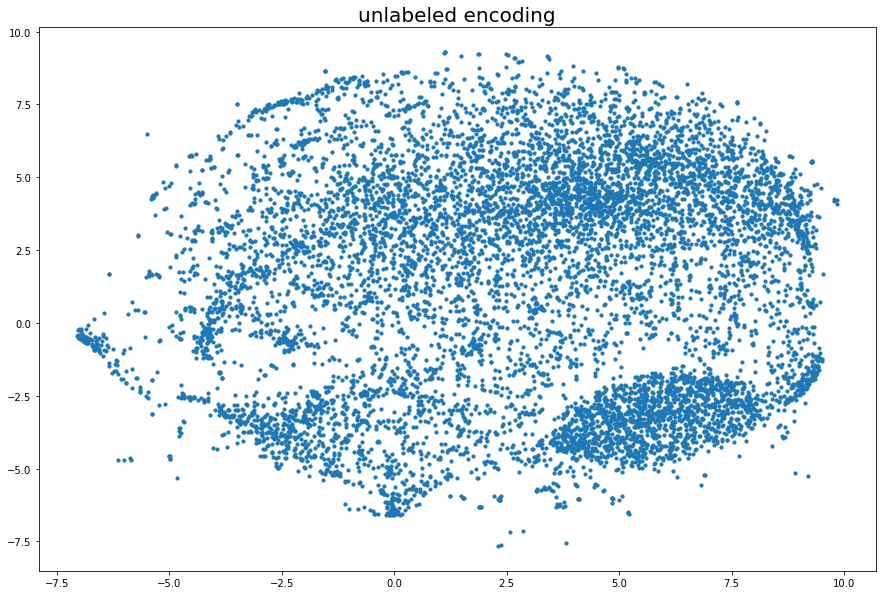

In [21]:
plot_tsne_df(tsne_df)

In [22]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [23]:
######################

In [24]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.sum()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [25]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [26]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity      mass  number_of_atoms  volume
0  AAA             5.4  213.2337             39.0   265.8
1  LLL            11.4  339.4728             66.0   500.1
2  ALA             7.4  255.3134             48.0   343.9
3  LAA             7.4  255.3134             48.0   343.9
4  AAL             7.4  255.3134             48.0   343.9

In [27]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity      mass  number_of_atoms  volume        x0        x1
0  AAA             5.4  213.2337             39.0   265.8  1.568249  7.383471
1  LLL            11.4  339.4728             66.0   500.1  7.284073  3.539854
2  ALA             7.4  255.3134             48.0   343.9  3.297037  4.587290
3  LAA             7.4  255.3134             48.0   343.9 -1.103518 -3.962784
4  AAL             7.4  255.3134             48.0   343.9  0.110943 -6.094039

In [28]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

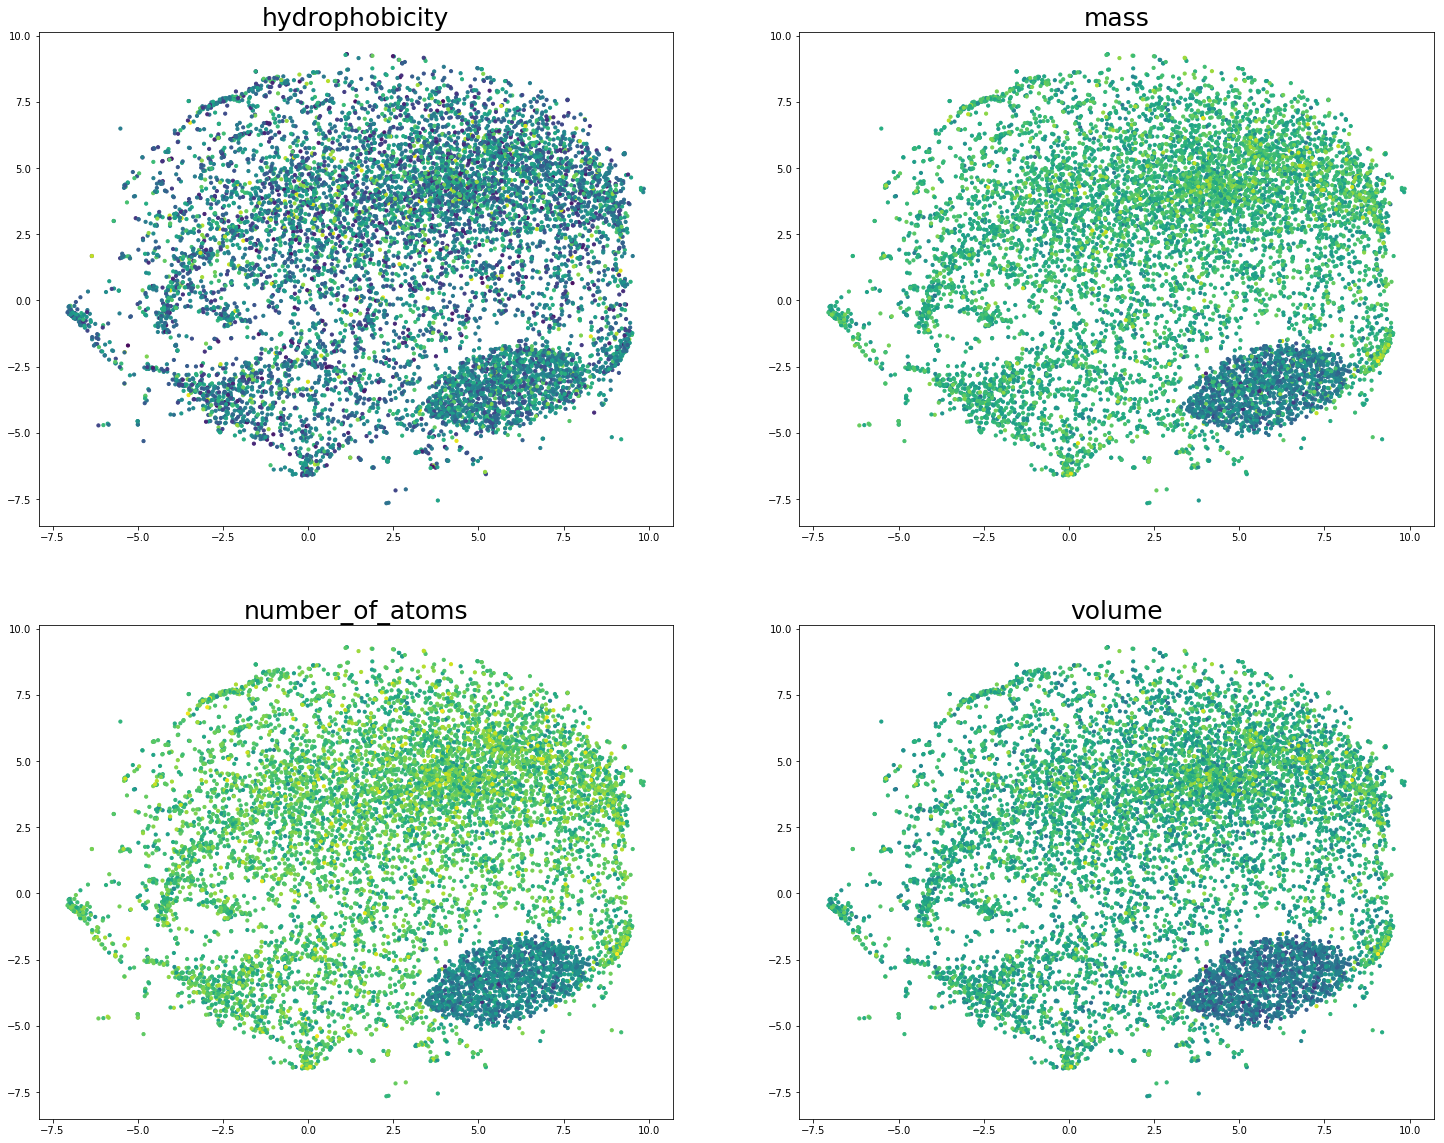

In [29]:
plot_embedding_properties(final_df)

In [30]:
######################

In [31]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

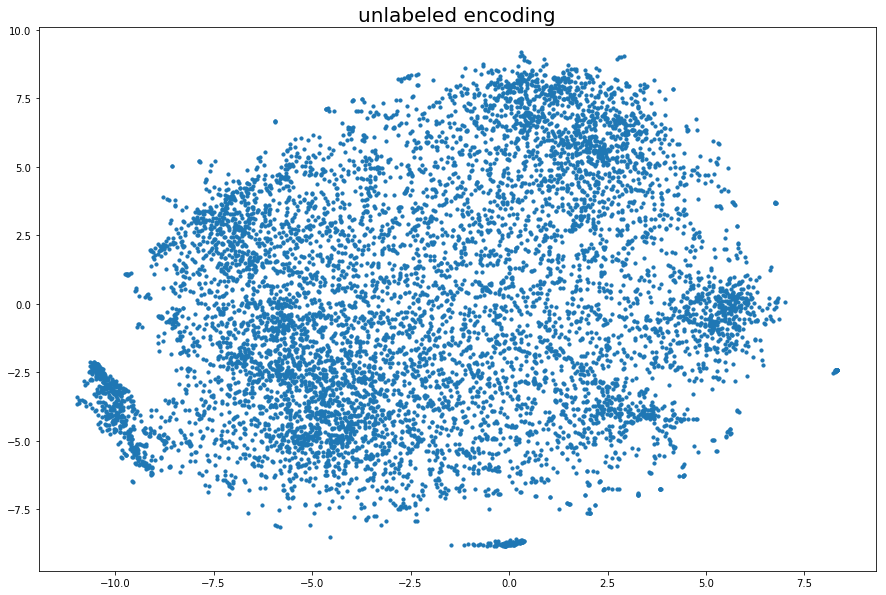

In [32]:
plot_tsne_df(gensim_tsne_df)

In [33]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

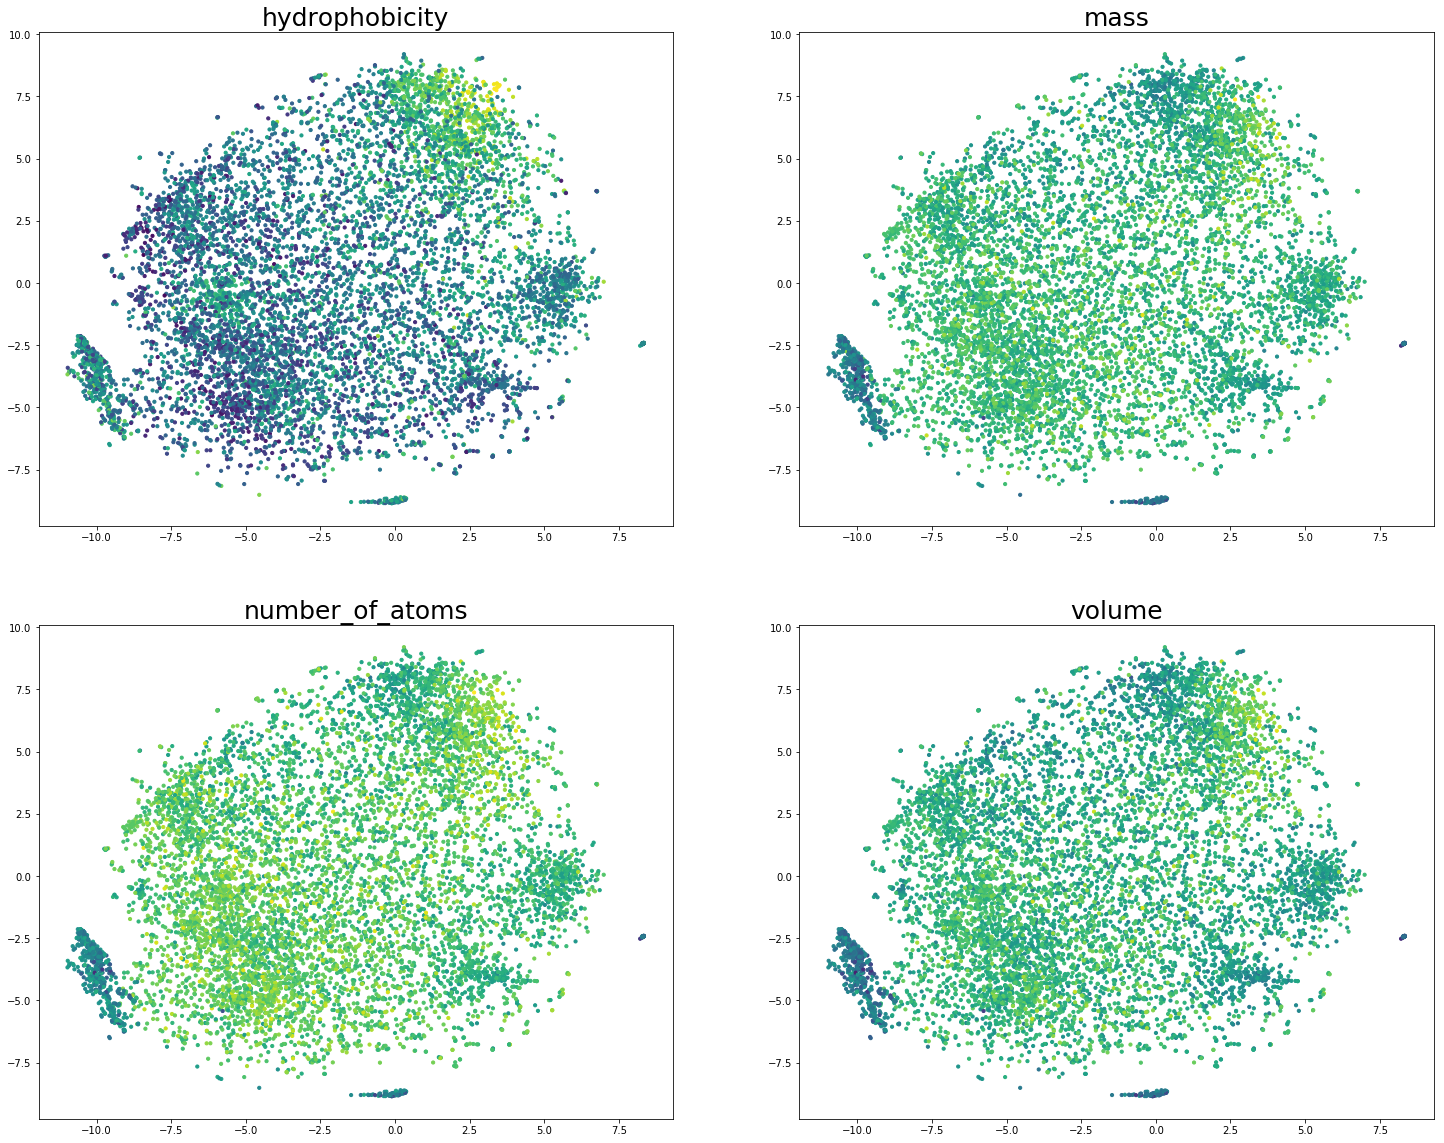

In [34]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/